In [1]:
import pandas as pd
import numpy as np
import os
from os import path
import shutil
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
import re
import traceback
%matplotlib inline

In [2]:
# focus on three regions now
regions = [
    "Burgenland",
    "Kärnten",
    "Niederösterreich",
    "Oberösterreich",
    "Salzburg",
    "Steiermark",
    "Tirol",
    "Vorarlberg",
    "Wien"
]
region_dirs = ["/users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/ehyd_messstellen_{}_gw_{}".format(num, regions[idx]) for idx, num in enumerate(range(1, len(regions)+1))]
region_dirs

['/users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/ehyd_messstellen_1_gw_Burgenland',
 '/users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/ehyd_messstellen_2_gw_Kärnten',
 '/users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/ehyd_messstellen_3_gw_Niederösterreich',
 '/users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/ehyd_messstellen_4_gw_Oberösterreich',
 '/users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/ehyd_messstellen_5_gw_Salzburg',
 '/users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/ehyd_messstellen_6_gw_Steiermark',
 '/users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/ehyd_messstellen_7_gw_Tirol',
 '/users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/ehyd_messstellen_8_gw_Vorarlberg',
 '/users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/ehyd_messstellen_9_gw_Wien']

## Add Exogenous Features to Processed data

In [219]:
def add_exogenous_features(region, region_dir, df_recursive_temp, folder_name, debugging=False):

    index = region_dir.find("/raw/")
    
    val_col_name = "gw-level"
    
    region_dir = region_dir[:index + len('/raw/')]
    
    folder_dir = path.join(region_dir, folder_name)
    
    print("> Processing --{}..".format(folder_name))
    
    # clean previous processing output
    output_dir = path.join(region_dir, "clean_processed_data")
    
    try:
        shutil.rmtree(output_dir)
    except:
        pass
    os.mkdir(output_dir)
    
    filenames = os.listdir(folder_dir)
    for filename in filenames:

        mp_num = filename.split(".")[0].split("-")[-1]
        
        filepath = path.join(folder_dir, filename)
        
        # process only files (don't iterate over output dir)
        if not path.isfile(filepath):
            continue
     
        df = pd.read_csv(filepath, encoding='ISO-8859-1')[["date","gw-level","temp"]]
        df['date'] = pd.to_datetime(df['date'])
        
        df_rescur_id = df_recursive_temp[["date", mp_num]]
        date_recur_results_dict = df_rescur_id.set_index("date")[mp_num].to_dict()

        # fill the temp nan with recursive results
        df.loc[df['temp'].isna(), 'temp'] = df.loc[df['temp'].isna(), 'date'].map(date_recur_results_dict)
    
    
        # add temp features
        df['temp_roll_mean_1_year'] = df['temp'].rolling(12, closed='left').mean()
        df['temp_roll_mean_2_year'] = df['temp'].rolling(24, closed='left').mean()
        df['temp_roll_max_1_year'] = df['temp'].rolling(12, closed='left').max()
        df['temp_roll_min_1_year'] = df['temp'].rolling(12, closed='left').min()

        
        # add calender features
        df["month"] = df["date"].dt.month
        df["year"] = df["date"].dt.year
        df["quarter"] = df["date"].dt.quarter

        # add season features
        df["season"] = df["date"].dt.month.apply(get_season)
        df["weather"] = df["date"].dt.month.apply(get_weather)
        df["season"] = df["season"].astype("category")
        df["weather"] = df["weather"].astype("category")
        
        # cyclic calender and seasonal features
        month_cyclic = cyclical_encoded(df["month"], cycle_length=24)
        quarter_cyclic = cyclical_encoded(df["quarter"], cycle_length=4)

        # merge the df to the cyclic the features
        df_exogenous_features = pd.concat([df,month_cyclic, quarter_cyclic], axis=1)

        # add intereaction between exogenous varibles
        transformer_poly = PolynomialFeatures(
        degree           = 2,
        interaction_only = True,
        include_bias     = False
        ).set_output(transform="pandas")
    
        # pick columns for exgennous varibles for intereactions
        copy_df = df_exogenous_features.copy()
        copy_df.drop(["season","weather","date",val_col_name], axis=1, inplace=True)
        poly_cols = copy_df.columns.tolist()
    
        poly_features = transformer_poly.fit_transform(df_exogenous_features[poly_cols].dropna())
        poly_features = poly_features.drop(columns=poly_cols)
        poly_features.columns = [f"poly_{col}" for col in poly_features.columns]
        poly_features.columns = poly_features.columns.str.replace(" ", "_")
        df_exogenous_features = pd.concat([df_exogenous_features, poly_features], axis=1)

        # Set the last 26 entries of the 'temp' column to 0.0
        df_exogenous_features.loc[df_exogenous_features.index[-26:], 'gw-level'] = 0.0

        df_exogenous_features.dropna(inplace=True)
        df_exogenous_features['temp_roll_mean_1_year'] = df_exogenous_features['temp_roll_mean_1_year'].round(2)
        df_exogenous_features['temp_roll_mean_2_year'] = df_exogenous_features['temp_roll_mean_2_year'].round(2)
        df_exogenous_features.set_index("date", inplace=True)
        
        # save processed data to file
        out_filename = "processed_{}".format(filename)
        file_path = path.join(output_dir, out_filename)
        df_exogenous_features.to_csv(file_path)
    
        
        # if debugging, process only one file from each sub dir 
        if debugging:
            break
        
    print("\t- Done!")

    return None

In [220]:
# Define a function to map month to season for exogenous varibles
def get_season(month):
    if month in [3.0, 4.0, 5.0]:
        return 'spring'
    elif month in [6.0, 7.0, 8.0]:
        return 'summer'
    elif month in [9.0, 10.0, 11.0]:
        return 'Fall'
    else:  # months 12.0, 1.0, 2.0
        return 'winter'

# information from www.weatherspark.com site
def get_weather(month):
    if month in [1, 2, 12]:
        return "freezing"
    elif month in [3, 11]:
        return "cold"
    elif month in [4,10]:
        return "cool"
    elif month in [5, 6, 9]:
        return "comfortable"
    else: # 7 & 8
        return "warm"

def cyclical_encoded(data, cycle_length):
    """ function to capture pattern on calender features """

    sin = np.sin(2 * np.pi * data/cycle_length)
    cos = np.cos(2 * np.pi * data/cycle_length)
    result =  pd.DataFrame({
                  f"{data.name}_sin": sin,
                  f"{data.name}_cos": cos
              })

    return result

def process_temp_files(region, region_dir, df_recursive, test_ids):
    
    # process and manipulate region files into clean .csv files
    FILE_PROCESSING_DEBUGGING = False # False => process  all files     
    folder_name = "temp_processed_data"
    
    add_exogenous_features(region, region_dir, df_recursive, folder_name, debugging=FILE_PROCESSING_DEBUGGING)

In [221]:
recursive_path = "/users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/df_submission_temp.csv"
df_recursive = pd.read_csv(recursive_path)
df_recursive = df_recursive.rename(columns={"Unnamed: 0": "date"})
df_recursive['date'] = pd.to_datetime(df_recursive['date'])

In [222]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    for i in range(1):
        region_idx = i
        region = regions[region_idx]
        region_dir = region_dirs[region_idx]
        process_temp_files(region, region_dir, df_recursive, test_ids)

> Processing --temp_processed_data..
	- Done!


In [6]:
# check if the data is 487 in total as given on the deliverables
processed_data_dir = "/users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/clean_processed_data"
files = os.listdir(processed_data_dir)
print(f" Number of processed data : {len(files)}")

 Number of processed data : 487


In [224]:
# check irregularity in the datetime rangeindex
counter = 0
filenames_with_fault = []
for filename in files:
    path = os.path.join(processed_data_dir, filename)
    df = pd.read_csv(path)
    df.set_index("date", inplace=True)
    df_total = len(df.index)
    time_range = len(pd.date_range(start=df.index.min(), end=df.index.max(), freq='MS'))
    if df_total != time_range:
        counter += 1
        filenames_with_fault.append(filename)

print(counter)
filenames_with_fault

0


[]

In [226]:
total_files = len(files) 
split_files = total_files // 4

index = processed_data_dir.find("/raw/")
outward_dir = processed_data_dir[:index + len('/raw/')]

processed_data_1 = os.path.join(outward_dir, "clean_processed_data_part1")
processed_data_2 = os.path.join(outward_dir, "clean_processed_data_part2")
processed_data_3 = os.path.join(outward_dir, "clean_processed_data_part3")
processed_data_4 = os.path.join(outward_dir, "clean_processed_data_part4")

if not os.path.exists(processed_data_1):
    os.mkdir(processed_data_1)
    
if not os.path.exists(processed_data_2):
    os.mkdir(processed_data_2)

if not os.path.exists(processed_data_3):
    os.mkdir(processed_data_3)

if not os.path.exists(processed_data_4):
    os.mkdir(processed_data_4)
    
for i, filename in enumerate(files):
    filepath = os.path.join(processed_data_dir, filename)
    if i <= split_files:
        new_filepath = os.path.join(processed_data_1, filename)
        shutil.copy(filepath, new_filepath)
    elif i > split_files and i <= split_files*2:
        new_filepath = os.path.join(processed_data_2, filename)
        shutil.copy(filepath, new_filepath)
    elif i > split_files and i <= split_files*3:
        new_filepath = os.path.join(processed_data_3, filename)
        shutil.copy(filepath, new_filepath)
    else:
        new_filepath = os.path.join(processed_data_4, filename)
        shutil.copy(filepath, new_filepath)

In [30]:
df = pd.read_csv("/users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/clean_processed_data/processed_Burgenland-335547.csv")
df['date'] = pd.to_datetime(df['date'])
df.head(3)

,date,gw-level,temp,temp_roll_mean_1_year,temp_roll_mean_2_year,temp_roll_max_1_year,temp_roll_min_1_year,month,year,quarter,...,poly_quarter_month_sin,poly_quarter_month_cos,poly_quarter_quarter_sin,poly_quarter_quarter_cos,poly_month_sin_month_cos,poly_month_sin_quarter_sin,poly_month_sin_quarter_cos,poly_month_cos_quarter_sin,poly_month_cos_quarter_cos,poly_quarter_sin_quarter_cos
0,1995-01-01,121.21,11.2,11.07,11.11,11.2,11.0,1,1995,1,...,0.258819,0.965926,1.0,6.123234e-17,0.250000,0.258819,1.584810e-17,0.965926,5.914590e-17,6.123234e-17
1,1995-02-01,121.21,11.3,11.08,11.12,11.2,11.0,2,1995,1,...,0.500000,0.866025,1.0,6.123234e-17,0.433013,0.500000,3.061617e-17,0.866025,5.302876e-17,6.123234e-17
2,1995-03-01,121.26,11.2,11.10,11.13,11.3,11.0,3,1995,1,...,0.707107,0.707107,1.0,6.123234e-17,0.500000,0.707107,4.329780e-17,0.707107,4.329780e-17,6.123234e-17


In [31]:
df_sl = df[df["date"] >= "2020-01-01"]
df_sl

,date,gw-level,temp,temp_roll_mean_1_year,temp_roll_mean_2_year,temp_roll_max_1_year,temp_roll_min_1_year,month,year,quarter,...,poly_quarter_month_sin,poly_quarter_month_cos,poly_quarter_quarter_sin,poly_quarter_quarter_cos,poly_month_sin_month_cos,poly_month_sin_quarter_sin,poly_month_sin_quarter_cos,poly_month_cos_quarter_sin,poly_month_cos_quarter_cos,poly_quarter_sin_quarter_cos
300,2020-01-01,121.27,12.30,12.50,12.54,12.70,12.40,1,2020,1,...,2.588190e-01,9.659258e-01,1.000000e+00,6.123234e-17,2.500000e-01,2.588190e-01,1.584810e-17,9.659258e-01,5.914590e-17,6.123234e-17
301,2020-02-01,121.23,12.40,12.49,12.54,12.70,12.30,2,2020,1,...,5.000000e-01,8.660254e-01,1.000000e+00,6.123234e-17,4.330127e-01,5.000000e-01,3.061617e-17,8.660254e-01,5.302876e-17,6.123234e-17
302,2020-03-01,121.20,12.40,12.48,12.55,12.70,12.30,3,2020,1,...,7.071068e-01,7.071068e-01,1.000000e+00,6.123234e-17,5.000000e-01,7.071068e-01,4.329780e-17,7.071068e-01,4.329780e-17,6.123234e-17
303,2020-04-01,121.17,12.50,12.48,12.55,12.70,12.30,4,2020,2,...,1.732051e+00,1.000000e+00,2.449294e-16,-2.000000e+00,4.330127e-01,1.060575e-16,-8.660254e-01,6.123234e-17,-5.000000e-01,-1.224647e-16
304,2020-05-01,121.14,12.50,12.48,12.53,12.70,12.30,5,2020,2,...,1.931852e+00,5.176381e-01,2.449294e-16,-2.000000e+00,2.500000e-01,1.182918e-16,-9.659258e-01,3.169619e-17,-2.588190e-01,-1.224647e-16
305,2020-06-01,121.12,12.60,12.48,12.52,12.70,12.30,6,2020,2,...,2.000000e+00,1.224647e-16,2.449294e-16,-2.000000e+00,6.123234e-17,1.224647e-16,-1.000000e+00,7.498799e-33,-6.123234e-17,-1.224647e-16
306,2020-07-01,121.12,12.60,12.48,12.51,12.70,12.30,7,2020,3,...,2.897777e+00,-7.764571e-01,-3.000000e+00,-5.510911e-16,-2.500000e-01,-9.659258e-01,-1.774377e-16,2.588190e-01,4.754429e-17,1.836970e-16
307,2020-08-01,121.06,12.50,12.48,12.50,12.70,12.30,8,2020,3,...,2.598076e+00,-1.500000e+00,-3.000000e+00,-5.510911e-16,-4.330127e-01,-8.660254e-01,-1.590863e-16,5.000000e-01,9.184851e-17,1.836970e-16
308,2020-09-01,121.07,12.50,12.46,12.49,12.60,12.30,9,2020,3,...,2.121320e+00,-2.121320e+00,-3.000000e+00,-5.510911e-16,-5.000000e-01,-7.071068e-01,-1.298934e-16,7.071068e-01,1.298934e-16,1.836970e-16
309,2020-10-01,121.11,12.50,12.46,12.49,12.60,12.30,10,2020,4,...,2.000000e+00,-3.464102e+00,-9.797174e-16,4.000000e+00,-4.330127e-01,-1.224647e-16,5.000000e-01,2.121150e-16,-8.660254e-01,-2.449294e-16


Text(0.5, 1.0, 'GW distribution by month')

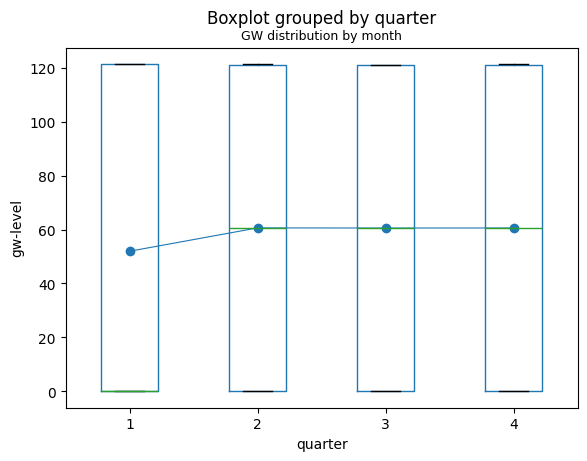

In [39]:
df_sl.boxplot(column='gw-level', by='quarter')
df_sl.groupby('quarter')['gw-level'].mean().plot(style='o-', linewidth=0.8)
plt.ylabel('gw-level')
plt.title('GW distribution by month', fontsize=9)